In [1]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
df = pd.read_csv("Brownlow Full Database.csv")

def calculate_margin(row):
    if(row['Team'] == row['Home_Team']):
        return row['Home_Score'] - row['Away_Score']
    else:
        return row['Away_Score'] - row['Home_Score']
    
    
df = df.iloc[:, :-4]
df['Winning_Margin'] = df.apply(lambda x: calculate_margin(x), axis=1)
df = df.iloc[:, 10:]

In [3]:
def sample_no_votes(row):
    if row['Brownlow_Votes'] > 0:
        return True
    else:
        return True if random.randint(0, 100) < 10 else False


In [4]:
df['keep'] = df.apply(lambda x: sample_no_votes(x), axis=1)
df_balanced = df.drop(df[df.keep == False].index)

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [6]:
X = df_balanced.drop([
    'Contested_Possessions', # values not recorded in 2012 data
    'Uncontested_Possessions', # values not recorded in 2012 data
    'Brownlow_Votes',
    'keep'
], axis=1).values

y = df_balanced['Brownlow_Votes'].fillna(0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

The optimal number of neighbors is 27


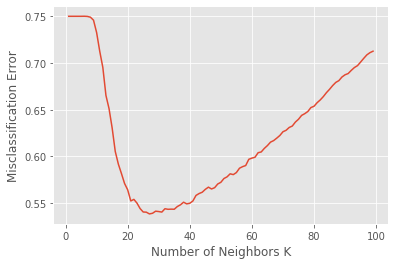

In [10]:
# creating odd list of K for KNN
radius = list(range(1, 100, 1))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in radius:
    knn = RadiusNeighborsClassifier(radius=k, outlier_label=0)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='balanced_accuracy')
    cv_scores.append(scores.mean())
    
    
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = radius[mse.index(min(mse))]
print("The optimal radius is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(radius, mse)
plt.xlabel("Optimal Radius K")
plt.ylabel("Misclassification Error")
plt.show()

Normalized confusion matrix
[[0.93852814 0.03290043 0.01904762 0.00952381]
 [0.39183673 0.19183673 0.19591837 0.22040816]
 [0.2605364  0.17624521 0.25287356 0.31034483]
 [0.14532872 0.14878893 0.2283737  0.47750865]]


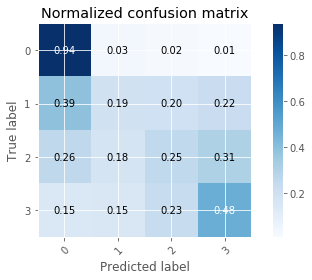

In [12]:
# instantiate learning model (k = 3)
knn = RadiusNeighborsClassifier(radius=27, outlier_label=0)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)


plot_confusion_matrix(y_test, pred, classes=['0','1','2','3'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [13]:
df2019 = pd.read_csv("2019 Brownlow Match Data.csv")
df2019 = df2019.iloc[:, :-4]
df2019['Winning_Margin'] = df2019.apply(lambda x: calculate_margin(x), axis=1)
df2019 = df2019.iloc[:, 10:]
df2019.shape

X = df2019.drop([
    'Contested_Possessions', # values not recorded in 2012 data
    'Uncontested_Possessions' # values not recorded in 2012 data
], axis=1).values

In [15]:
hard_pred = knn.predict(X)

In [16]:
df2019_predictions = pd.read_csv("2019 Brownlow Match Data.csv")
df2019_predictions['Predicted_Votes'] = hard_pred.tolist()

In [17]:
# Group by player and sort form high votes to low
results = pd.DataFrame(data = df2019_predictions.groupby(['Year','player_name','Team'])['Predicted_Votes'].sum())
results = results.reset_index()
results = results.sort_values('Predicted_Votes', ascending=False);

# Display the top 20 predicted vote getters for 2016
results.head(n=20)

,Year,player_name,Team,Predicted_Votes
9,2019,Adam Treloar,COLL,33.0
242,2019,Jack Macrae,WB,32.0
494,2019,Patrick Dangerfield,GEEL,29.0
452,2019,Mitch Duncan,GEEL,27.0
588,2019,Tim Taranto,GWS,26.0
348,2019,Josh Dunkley,WB,26.0
167,2019,Dayne Zorko,BL,25.0
60,2019,Brad Crouch,ADEL,24.0
177,2019,Dustin Martin,RICH,23.0
461,2019,Nat Fyfe,FRE,23.0


In [19]:
df2019_predictions['prediction0'] = hard_pred[:,0] # Probably not needed
df2019_predictions['prediction1'] = hard_pred[:,1]
df2019_predictions['prediction2'] = hard_pred[:,2]
df2019_predictions['prediction3'] = hard_pred[:,3]

IndexError: too many indices for array

In [20]:
df2019_predictions.head()

,Unique_Game_ID,Year,Round,game_id,Home_Team,Home_Score,Away_Team,Away_Score,player_name,Team,...,Behinds,Goal_Assists,Goal_Percentage,Time_On_Ground_Percentage,AFL_Fantasy_Points,Champion_Data_Rating,Tackles_50,Metres_Gained,Score_Involvements,Predicted_Votes
0,1387,2019,1,1,CARL,64,RICH,97,Marc Murphy,CARL,...,0,0,100,87,97,14.9,0,530,7,0.0
1,1387,2019,1,1,CARL,64,RICH,97,Sam Petrevski-Seton,CARL,...,0,0,0,85,81,7.1,0,282,0,0.0
2,1387,2019,1,1,CARL,64,RICH,97,Nic Newman,CARL,...,0,0,100,84,115,15.9,0,584,4,1.0
3,1387,2019,1,1,CARL,64,RICH,97,Liam Jones,CARL,...,0,0,0,97,49,11.5,0,20,1,0.0
4,1387,2019,1,1,CARL,64,RICH,97,Andrew Phillips,CARL,...,0,0,0,79,83,9.7,2,163,2,0.0


In [121]:
df2019_predictions.to_csv('2019KNNClassification.csv')